### Import Libraries

In [1]:
# ==============================
# 📦 Import Libraries
# ==============================
import os
import cv2
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import keras_tuner as kt

# Set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Load and Data Preprocessing 

In [2]:
def load_images(image_dir, mask_dir, image_size=(128, 128)):
    images, masks = [], []
    for filename in sorted(os.listdir(image_dir)):
        if not filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            continue
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # assumes same name pattern

        if not os.path.exists(mask_path):
            print(f"Mask missing for: {filename}")
            continue

        img = load_img(img_path, color_mode='grayscale', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)
    return images, masks


base_path = "Dataset_Generated"
image_dir = os.path.join(base_path, 'img')
mask_dir = os.path.join(base_path, 'mask')

images, masks = load_images(image_dir, mask_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 170 images and 170 masks.


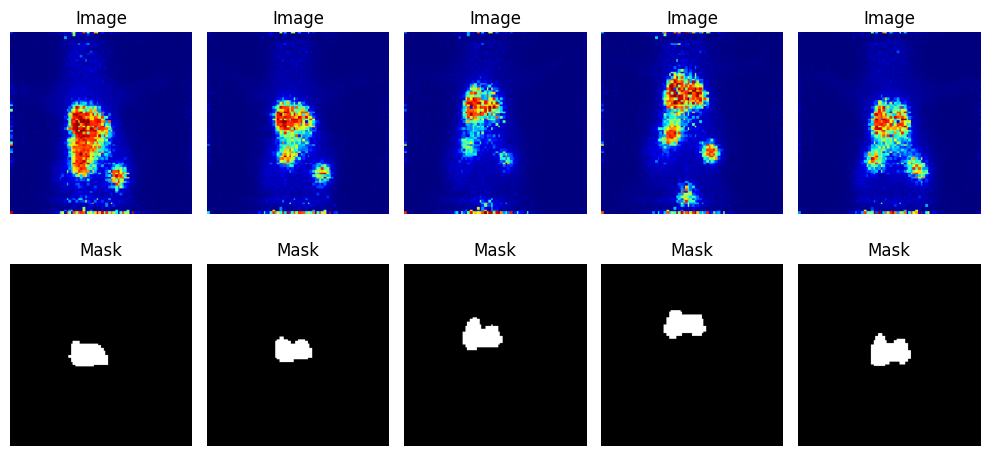

In [4]:
# Visualize some images and masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if i >= len(images):
            break
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[6*i].squeeze(), cmap='jet')
        plt.axis('off')
        plt.title("Image")
        
        # Display mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[6*i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks)

### Split Train/Test


In [5]:
# split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
print("Training:", X_train.shape, "Testing:", X_test.shape)

Training: (136, 128, 128, 1) Testing: (34, 128, 128, 1)


### Define U-Net Builder for Tuning

In [14]:
def build_unet_tuner(hp):
    inputs = Input((128, 128, 1))
    
    # Hyperparameters
    num_filters = hp.Choice('num_filters', values=[16, 32, 64])
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Encoder
    c1 = Conv2D(num_filters, 3, activation='relu', padding='same')(inputs)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(num_filters, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)
    
    c2 = Conv2D(num_filters*2, 3, activation='relu', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(num_filters*2, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)
    
    c3 = Conv2D(num_filters*4, 3, activation='relu', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(num_filters*4, 3, activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = Conv2DTranspose(num_filters*2, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c2])
    u1 = Conv2D(num_filters*2, 3, activation='relu', padding='same')(u1)
    u1 = Dropout(dropout_rate)(u1)
    u1 = Conv2D(num_filters*2, 3, activation='relu', padding='same')(u1)
    
    u2 = Conv2DTranspose(num_filters, 2, strides=2, padding='same')(u1)
    u2 = concatenate([u2, c1])
    u2 = Conv2D(num_filters, 3, activation='relu', padding='same')(u2)
    u2 = Dropout(dropout_rate)(u2)
    u2 = Conv2D(num_filters, 3, activation='relu', padding='same')(u2)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(u2)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


### Hyperparameter Tuning

In [15]:
tuner = kt.GridSearch(
    build_unet_tuner,
    objective="val_loss",
    max_trials=5,
    directory="unet_tuner_dir",
    project_name="unet_gridsearch",
)

tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=3,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]
)

tuner.results_summary()


Reloading Tuner from unet_tuner_dir\unet_gridsearch\tuner0.json
Search space summary
Default search space size: 3
num_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Results summary
Results in unet_tuner_dir\unet_gridsearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.1
learning_rate: 0.01
Score: 0.03014872595667839

Trial 3 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.03362995386123657

Trial 1 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.03672744333744049

Trial 4 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.03719605877

In [16]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
Best Hyperparameters:
num_filters = {best_hps.get('num_filters')}
dropout_rate = {best_hps.get('dropout_rate')}
learning_rate = {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
num_filters = 16
dropout_rate = 0.1
learning_rate = 0.01



In [17]:
model = build_unet_tuner(best_hps)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=4,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.9525 - loss: 0.2029 - val_accuracy: 0.9732 - val_loss: 0.0567
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9744 - loss: 0.0489 - val_accuracy: 0.9732 - val_loss: 0.0505
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9770 - loss: 0.0449 - val_accuracy: 0.9813 - val_loss: 0.0476
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9815 - loss: 0.0439 - val_accuracy: 0.9811 - val_loss: 0.0480
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9824 - loss: 0.0418 - val_accuracy: 0.9811 - val_loss: 0.0462
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9824 - loss: 0.0414 - val_accuracy: 0.9814 - val_loss: 0.0461
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9827 - loss: 0.0409 - val_accuracy: 0.9814 - val_loss: 0.0454
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9825 - loss: 0.0409 - val_accuracy: 0.981

In [18]:
model.save('model_1_Unet.h5')

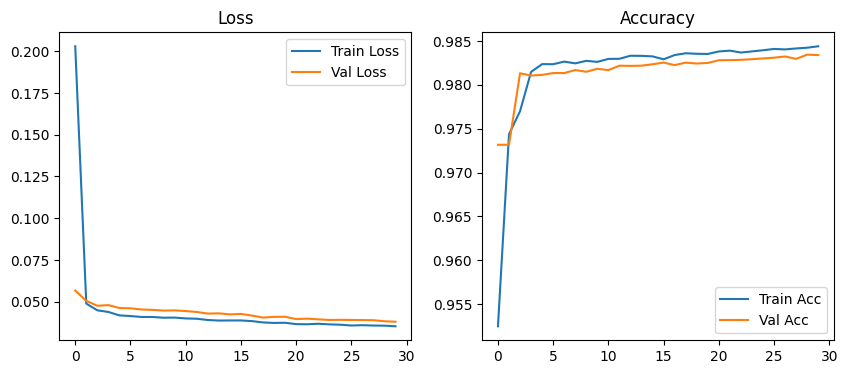

In [19]:
# -------------------------------
# Plot Training Curves
# -------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()


In [6]:
from tensorflow.keras.models import load_model

model = load_model('z_models/model_1_Unet.h5', compile=False)


In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

preds_test = model.predict(X_test)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice_scores = []
precisions = []
recalls = []
accuracies = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

for i in range(len(X_test)):
    y_true = y_test[i].squeeze()
    y_pred = preds_test_t[i].squeeze()
    
    # Flatten for sklearn metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    dice_scores.append(dice_coef(y_true, y_pred))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))
    accuracies.append(accuracy_score(y_true_flat, y_pred_flat))
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1]).ravel()
    TP_total += tp
    TN_total += tn
    FP_total += fp
    FN_total += fn

print(f"Average Dice Coefficient: {np.mean(dice_scores):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")

print("\nTotal Confusion Matrix:")
print(f"TP: {TP_total}, TN: {TN_total}, FP: {FP_total}, FN: {FN_total}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
Average Dice Coefficient: 0.669
Average Precision: 0.828
Average Recall: 0.610
Average Accuracy: 0.985

Total Confusion Matrix:
TP: 8949, TN: 539754, FP: 2363, FN: 5990


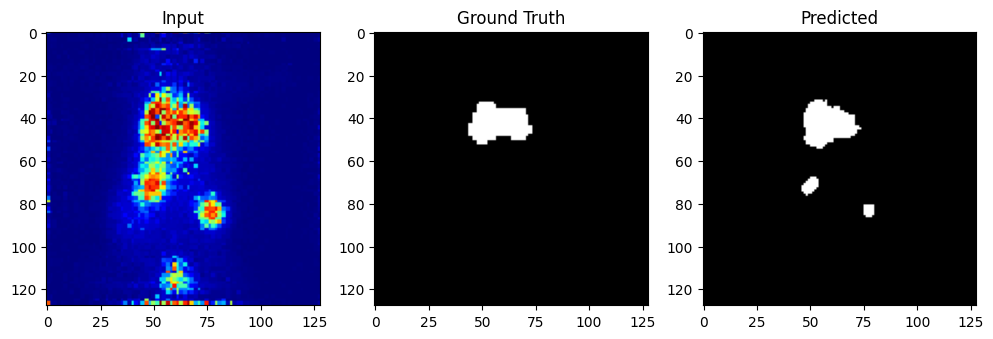

In [23]:
# -------------------------------
# Visualize a Random Prediction
# -------------------------------
import random
ix = random.randint(0, len(X_test) - 1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_test[ix].squeeze(), cmap='jet'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(y_test[ix].squeeze(), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,3); plt.imshow(preds_test_t[ix].squeeze(), cmap='gray'); plt.title('Predicted')
plt.show()